In [10]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib widget

In [41]:
def f_( y ):
  return jnp.asarray( [y[2], 1000*(1-y[1]**2)*y[2]-y[1]] )

def f(t, y):
  return np.array(f_( jnp.append(jnp.asarray([t]),y) ) )

def J_( y ):
  return jax.jacfwd(f_)(y)

def J(t, y):
  j = J_( jnp.append(jnp.asarray([t]),y) ) 
  return np.array(j[:,1:])


In [42]:
sol_bdf = solve_ivp(f, (0,3000), (2.0, 0.0), jac=J, method='BDF' ) 

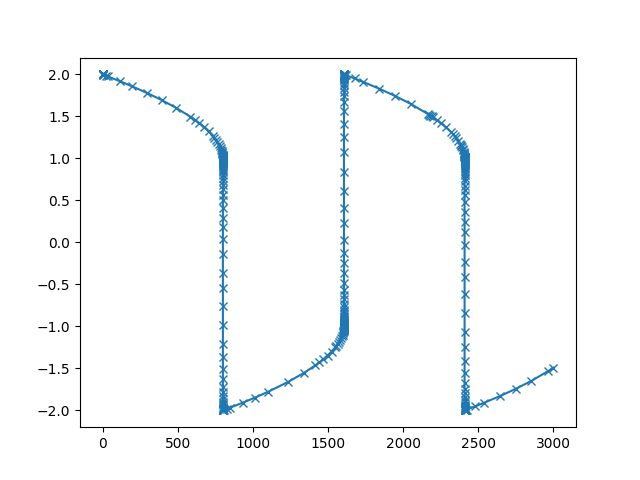

In [43]:
fig, ax = plt.subplots()
ax.plot( sol_bdf.t, sol_bdf.y[0], 'x-' )
# ax.plot( sol_rk45.t, sol_rk45.y[0], 'x-' )

In [1117]:
Omegab = 0.045
Omegam = 0.30
OmegaL = 0.70
YHe = 0.24
H0 = 70.0
Tcmb = 2.724

h = H0/100.0
obh2 = Omegab*h**2

mH = 0.93878299831e9      # Hydrogen atom mass in eV/c^2 
kBoltz = 8.617343e-5      # Boltzmann constant in eV/K 
L2s1s = 8.2206            # 2s -> 1s two-photon decay rate in s^{-1} (Labzowsky et al 2005) 
EI = 13.598286071938324   # Hydrogen ionization energy in eV, reduced mass, no relativistic corrections
Mpc_o_c = 3.085678e22 / 2.99792458e8 # convert from Hz to Mpc

# c  grho gives the contribution to the expansion rate from: (g) photons,
# c  (r) one flavor of relativistic neutrino (2 degrees of freedom),
# c  (m) nonrelativistic matter (for Omega=1).  grho is actually
# c  8*pi*G*rho/c^2 at a=1, with units of Mpc**(-2).
# c  a=tau(Mpc)*adotrad, with a=1 today
grhom = 3.3379e-11 * H0**2
grhog = 1.4952e-13 * Tcmb**4
grhor = 3.3957e-14 * Tcmb**4
adotrad = 2.8948e-7 * Tcmb**2

nH0 = 11.223846333047e-6*obh2*(1-YHe)
fHe = YHe/(1-YHe)/3.97153


# **************************************************************************************************
# Case-B recombination coefficient and photoionization rate, fit of Pequignot et al 1991, in cm^3 s^{-1}
# INPUT TEMPERATURE ASSUMED TO BE ALREADY RESCALED FOR VALUES OF alpha_fs and me
# ***************************************************************************************************
def alphaB_PPB( TM ):
  t4 = TM/kBoltz/1e4
  return 4.309e-13 * t4**-0.6166 / (1.+ 0.6703 * t4**0.5300)

# **************************************************************************************************
# Effective three-level atom model with adjustable fudge factor.
# Fudge = 1 is Peebles' model. Fudge = 1.14 is similar to RecFast (Seager et al. 1999, 2000).
# Changes (May 2012):
# - Correction: detailed balance implies that the photoionization rate is proportional to alpha_B(Tr) rather than alpha_B(Tm)
# - Analytically subtract nearly-cancelling terms at high-z
# - Explicit dependence on alpha_fs and m_e now accounted for
# - Added explicit dependence on xHII, which is not necessarily equal to xe if Helium has not entirely recombined
# December 2014:
# - Added additional ionization and excitations due to additional energy injection.
#   dEdtdV is the rate of energy deposition rate per unit volume (in eV/s/cm^3)
# ***************************************************************************************************
def rec_TLA_dxHIIdtau( xe, xHII, nH, H, TM, TR, Fudge=1.0):

  LYA_FACT = 4.662899067555897e15 # 8pi/(3 lambda_Lya^3) in cm^(-3), used as prefactor for Lyman-alpha Sobolev escape probability 
  SAHA_FACT= 3.016103031869581e21 # (2 pi mu_e * EI/EI0)^(3/2)/h^3 in eV^(-3/2) cm^(-3), used for Saha equilibrium and detailed balance

  RLya       = LYA_FACT * H / nH / (1.-xHII)
  alphaB_TM  = Fudge * alphaB_PPB(TM)
  alphaB_TR  = Fudge * alphaB_PPB(TR)

  four_betaB = SAHA_FACT * TR * jnp.sqrt(TR) * jnp.exp(-0.25*EI/TR) * alphaB_TR
  C          = (3.*RLya + L2s1s)/(3.*RLya + L2s1s + four_betaB);    # Peebles' C-factor 

  s          = SAHA_FACT * TR * jnp.sqrt(TR) * jnp.exp(-EI/TR)/nH
  Dxe2       = xe*xHII - s*(1.-xHII)    # xe xp - xe xp[Saha eq with 1s] -- gives more compact expressions 
  DalphaB    = alphaB_TM - alphaB_TR

  return -nH*(s*(1.-xHII)*DalphaB + Dxe2*alphaB_TM)*C #+ (cosmo->inj_params->ion + (1.-C)*cosmo->inj_params->exclya);



def ionize( tempb: float, a: float, adot: float, xe: float) -> float:
        # ... switch for fully implicit (switch=1.0) or semi implicit (switch=0.5);
        # iswitch = 0.5

        tion = 1.5789e5  # ionization temperature
        beta0 = 43.082  # ionizatio coefficient (?)
        dec2g = 8.468e14  # two photon decay rate (in 1/Mpc)
        # recombination coefficient (in sqrt(K)/Mpc).
        alpha0 = 2.3866e-6 * (1.0 - YHe) * Omegab * H0**2
        # coefficient for correction of radiative decay (dimensionless)
        crec = 8.0138e-26 * (1.0 - YHe) * Omegab * H0**2
        # recombination and ionization rates.
        phi2 = jnp.maximum(0.448 * jnp.log(tion / tempb), 0.0)
        alpha = alpha0 / jnp.sqrt(tempb) * phi2 / a**3
        beta = tempb * phi2 * jnp.exp(beta0 - tion / tempb)
        # ... Peebles' correction factor
        cp1 = crec * dec2g * (1.0 - xe) / (a * adot)
        cp2 = crec * tempb * phi2 * jnp.exp(beta0 - 0.25 * tion / tempb) * (1.0 - xe) / (a * adot)
        # cpeebles = jax.lax.cond( tempb>=200.0, lambda zz:(1.0 + cp1) / (1.0 + cp1 + cp2), lambda zz:1.0)

        if tempb>=200.0:
              cpeebles = (1.0 + cp1) / (1.0 + cp1 + cp2)
        else:
              cpeebles = 1.0
        
        # ... integrate dxe=bb*(1-xe)-aa*xe*xe by averaging rhs at current tau
        # ... (fraction 1-iswitch) and future tau (fraction iswitch).
        return a * cpeebles * (beta * (1-xe) - alpha * xe**2)

def ionHe(self, tempb: float, a: float, x0: float, x1: float, x2: float) -> tuple[float, float]:
        """Compute the helium ionization fractions using the Saha equation

        Args:
            tempb (float): baryon temperature
            a (float):  scale factor
            x0 (float): hydrogen ionization fraction n(H+)/n(H) (input)
            x1 (float): helium first ionization fraction n(He+)/n(He) (in&out)
            x2 (float): helium second ionization fraction n(He++)/n(He) (in&out)

        Returns:
            tuple[float,float]: x1,x2
        """
        tion1 = 2.855e5
        tion2 = 6.313e5

        # ... constant for electron partition function per baryon
        b0 = 2.150e24 / ((1.0 - YHe) * Omegab * H0**2)
        # ... electron partition function per baryon
        b = b0 * a**3 * tempb * jnp.sqrt(tempb)
        # ... dimensionless right-hand sides in Saha equations
        r1 = 4.0 * b * jnp.exp(-tion1 / tempb)
        r2 = b * jnp.exp(-tion2 / tempb)

        # ... solve coupled equations iteratively
        c = 0.25 * YHe / (1.0 - YHe)
        err = 1.0
        niter = 0

        # while err > 1e-12:
        for niter in range(1,5):
            xe = x0 + c * (x1 + 2.0 * x2)
            x2new = r1 * r2 / (r1 * r2 + xe * r1 + xe * xe)
            x1 = xe * r1 / (r1 * r2 + xe * r1 + xe * xe)
            err = jnp.fabs(x2new - x2)
            x2 = x2new
            niter += 1

        return (x1, x2)

def f_( y ):
    
    tau = y[0]
    a  = y[1]
    xe = y[2]
    Tm = jnp.exp(y[3])

    Tr  = Tcmb / a
    nH  = nH0 / a**3

    grho = (
        grhom * Omegam / a
        + (grhog + 3.0 * grhor) / a**2
        + grhom * OmegaL * a**2
    )
    adotoa = jnp.sqrt(grho / 3.0)
    dadtau = adotoa * a

    ############################################################################

    # x0 = 1.0
    # dxe = ionize( Tb, a, adotoa*a, xe )
    # x1, x2 = ionHe( Tb, a, xe, 1.0, 0.0, 1.0 ) #x1, x2)

    # dxedtau = dxe*a

    H = adotoa /a / Mpc_o_c 
    dxedtau = rec_TLA_dxHIIdtau( xe, xe, nH, H, 1e-5*kBoltz*Tm, 1e-5*kBoltz*Tr, 1.14 ) #* a


    # x1, x2 = ionHe( Tm, a, xe, 1.0, 0.0, 1.0 )
    # xe_all = xe + 0.25 * YHe / (1.0 - YHe) * (x1 + 2.0 * x2)
    
    ############################################################################

    #... Coefficient = 8 sigma_T a_r / (3 m_e c) [in 1/s = Hz]
    #... where a_r = 4 sigma / c where sigma = Stefan-Boltzmann constant
    #... Here Tr, Tb are the actual (not rescaled) temperatures 

    coefficient = 4.91466895548409e-22
    thomfac = coefficient * Mpc_o_c

    

    if (Tr/Tm-1.<1e-10) and (Tr>3000.):
        dTmdtau = -Tm*adotoa
    else:
        dTmdtau = -2.*Tm*adotoa + thomfac * Tr**4 * xe * (1.+xe+fHe) * (Tr-Tm) * a**3

    dTmdtau = -Tm*adotoa

    # dTmdtau = -2.*adotoa + 4.91466895548409e-22 * Mpc_o_c * Tr**4/Tb * xe/(1.+xe+fHe) * (Tr-Tb) * a**4
    dTmdtau /= Tm
    
    ############################################################################

    return jnp.asarray( [dadtau, dxedtau, dTmdtau] )

def f(t, y):
  return np.array(f_( jnp.append(jnp.asarray([t]),y) ) )

def J_( y ):
  return jax.jacfwd(f_)(y)

def J(t, y):
  j = J_( jnp.append(jnp.asarray([t]),y) ) 
  return np.array(j[:,1:])

In [1120]:
tau_start = 1e1
tau_max = 1e4
tau_out = np.geomspace(tau_start,tau_max,1000)

# xe0 = 1 + 0.5 * YHe / (1.0 - YHe)
xe0 = 1.0001
x1 = 0.0
x2 = 1.0


y0 = jnp.array([ tau_start * adotrad, xe0, jnp.log(Tcmb / (tau_start * adotrad)) ])
# sol = solve_ivp(f, (tau_start,tau_max), y0, t_eval=tau_out, jac=J, method='LSODA' ) 
sol = solve_ivp(f, (tau_start,tau_max), y0, t_eval=tau_out)

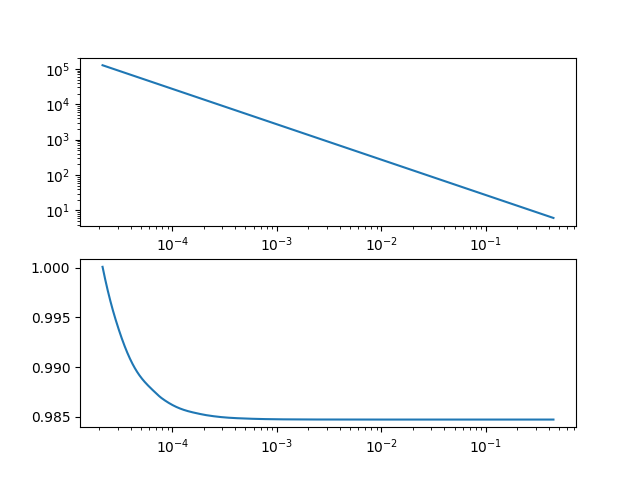

In [1121]:
fig, ax = plt.subplots(2)
ax[0].loglog( sol.y[0], np.exp(sol.y[2]),'-')
ax[1].semilogx( sol.y[0], sol.y[1],'-')
# ax[1].set_ylim(0,1.2)
# ax.loglog( sol.y[0], 2.726/sol.y[0])


In [957]:
sol.y

array([[2.14799245e-09, 2.15294902e-09, 2.15791703e-09, ...,
        2.13813451e-08, 2.14306845e-08, 2.14801378e-08],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [2.09608326e+01, 2.09588991e+01, 2.09569611e+01, ...,
        1.86699982e+01, 1.86676921e+01, 1.86653867e+01]])

In [628]:
sol.y

[]